In [26]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import pandas as pd
import json
from itertools import compress
import math

from scipy import signal 

import glob

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.utils 

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows, \
   intersection, reject_outliers, anglebetween, eye_outlier_removal_sigma, eye_outlier_removal_zero_values, validate_participant_seen_areas
from AngleHelpers import create_relative_directions

In [27]:
reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_dict_all.pickle"
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

correlation_dict_path = "./post_recorded_reference_data/corr_dict.pickle"
CORRELATION_DICT = load_from_disk(correlation_dict_path)

final_data_path = "/Volumes/LaCie/aMessdaten/LoopAR/Final_Filtered_Data/"

# Load data

In [8]:
# Exclude all participants that have less than two (complete) scenes besides the training scene
exclude_participant_ids = [
    "a5c5d2051bd1493ea79e1d565524610f", # ['MountainRoad.txt']
    "2462e5d82bc44a328934442cae03d83f", # ['MountainRoad.txt', 'TrainingScene.txt']
    "0c2734d5a8664e1abd2ffcf8aa6fa5d6", # ['TrainingScene.txt']
    "c685e206b2eb4702860bb908afe2a11f", # ['MountainRoad.txt', 'TrainingScene.txt']
    "28d1f769c1204e36a574c025d8e771c4", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "d5f3fa1c877f4afb9bc0250d5882c22c", # ['TrainingScene.txt']
    "f4c4e380b2b941e4a963fe12f4038865", # ['MountainRoad.txt', 'TrainingScene.txt']
    "1c293d21f60241008d6230a6f28e4079", # ['TrainingScene.txt']
    "3e3154cff72540e48eac982a379ce69f", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "1deaa8e567f1435da07c0817717ef4fe", # ['TrainingScene.txt']
    "28191a22a70d478b808eb8905e35c6ba", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "ac30f09446ec48289c41b66b1ba0d3f9", # ['TrainingScene.txt'] 
    "5b79b725686a4985b5caf35de0e06d43", # ['Incomplete.txt', 'TrainingScene.txt']
    "b482259cbb524e689a6e3859951bebf1", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "518e07b76d804110b035e3c774f52d5b", # ['TrainingScene.txt']
    "cc9284dfb5f645858196537e05c1959b", # ['MountainRoad.txt']
    "0cd51e7040bc43568284cdcedccfe0d3", # ['TrainingScene.txt']
    "d9cd9704a0064fed9993333363608346", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "5ff5cecd56f7486286ec386434ae9219", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "178dd53ce37a40b0accd7a59cc9035ac", # ['TrainingScene.txt']
    "1efd4163b5614c8e9eed8e04c0ceda3e", # ['MountainRoad.txt', 'TrainingScene.txt'] 
    "b74d6990eba645fa82fa2ab9fb0b5180", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "711fa186ae5e4d9fada5b0e0049a2074", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "83b00eb628b2446d992ac698026dfdc0", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "f2fb2a62a3ca4033b9005be13842e27c", # ['MountainRoad.txt']
    "0c0c45348e314379994333127e5456ae", # ['TrainingScene.txt']
    "7824cc42ee0447a4a2fa56b9c93bbabb", # ['TrainingScene.txt']
    "95228b7595954054ae2d11cfbd7623f8", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "a5a31c4af00b4199ac4c8760bfaa469e", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "addd1085215d42b38184517a2dc95d8d", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "f4db5c989fa64b90b31d396943964c12", # ['TrainingScene.txt']
    "a33a91bbd197432c91a8156f88e46c08", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "206b42297be84c7087da6c93f46615bd", # ['Incomplete.txt', 'MountainRoad.txt', 'TrainingScene.txt']
    "cf45d8bef0b842e5bac1b7022cc3c354", # ['MountainRoad.txt', 'TrainingScene.txt']
    "e9ec1e6c22c640168130d2756426666c", # ['TrainingScene.txt']
    "989685d9ca454491b184984695786e20", # ['TrainingScene.txt']
    "8f9b8786312349639e8811f451054df0", # ['MountainRoad.txt']
    "39e38c2aa06c42d79e50f36b631f9652", # ---- Some weird key error ---> files are empty for certain scenes
    "5e66bfb48366498aa83c364bf31c6059", # ---- Some weird key error
    "3358f368d8694472a86c4770d4f804bc", # ---- Some weird key error
    "95e8781012c94d37a222b5679724cb1d", # ---- Some weird key error
    "8626976ce8b14752be340be9f1070724", # ---- Some weird key error
    "ab79e465598844af94e9bfdfca116fc4", # ---- Some weird key error
    "6f7a67231a16454dbd657d2f48443aac", # ---- Some weird key error
    "2cae1d5a3c0c4872b2f397deb13ece71", # ---- Some weird key error
    "8b27ff8591af4cd79067cf156d23ab95", # ---- Some weird key error
    "8245ccbaba844032b08f7c33d9c4308a", # ---- Some weird key error 
    "d093379ce1224f1bb24b9730da105927", # ---- Some weird key error 
    "ff0cb5fdc1884204937eca64b52ee041", # ---- Some weird key error
    "05086cebdd4c45a084ed3ce6b25cc9e6", # ---- Some weird key error
    "4858c7aa9362421988e7c88d5adae755", # ---- Some weird key error
    "66bdb97a653b48f98c02d5e764089c00", # ---- Some weird key error
    "3100b15011da48d88fa3f7f053e4e19f", # ---- Some weird key error
    "39e5235b13274feb88430f08f3cd5369", # ---- Some weird key error
    "9b9220b8bf8c4e61adde8bc7571540ef", # ---- Some weird key error
    "a57132e2aeba484e8433ae8af9b1abbc", # ---- Some weird key error
    "3de6823af97441c18c8ca5f169b6e896", # ---- Some weird key error
    "3d865974f89e44c583e23e4f3c8f3d14", # ---- Some weird key error
    "011846a5c30c4325b45e439fc992f519", # ---- Some weird key error
    "951592742a88497989fbb71a65781639", # ---- Some weird key error 
    "867545b969cc4ff088b70eab632671dd", # ---- Some weird key error
    "0d72afe467e74d4fb717a4ab9bb128ac", # ---- Some weird key error
    "1d0296054e434021b3aa2b47b6c7d921", # ---- Number of supplied paths does not match 
    "0037b2329de444c18d751b4e79901b39", # ---- Calibration data seems to be missing
    "b89680ab48514db8bca8fcca1852f36d", # ---- Calibration data seems to be missing
    
    #####
    
    # These seem to later be causing nans, mostly likely due to interpolation of clusters 
    "81957954cd71450cacc5fd738dd9ebd2" # done, but has 3 segments where all values are 0 
    #"7e3a3b57dc2a436faf7a21f010206bb6" # done, but has 1 segment where all values are 0 
    "4a10fec1583843e5b1c82fb74fa7c775" # done, but has 7 segments where all values are 0
    "eadeee63de7f40a4b4375733651d5dd1" # done, but has 12 segments where all values are 0 
    #"8ba8fe140022448490326ad0d25ef5a3" # done, but has 2 segments where all values are 0 
    #"4702745fe0df4a778149aee6882a31de" # done, but has 1 segment where all values are 0
    "8e03eb1671774d3d9a35f97178902a45" # done, but has 7 segments where all values are 0
    
]

exclude_participant_ids = []

In [9]:
verbose = False

#participant_bootstrap_path = "/Volumes/LaCie/aMessdaten/LoopAR/Bootstrapped_Participants/"
participant_bootstrap_path = "./bootstrapped_participant_data/"
keep_participants_in_memory = False


eyes_paths  = ["/Volumes/LaCie/aMessdaten/LoopAR/Data_from_store/LoopAR Data/WestdriveLoopARData_left_complete/EyeTracking/","/Volumes/LaCie/aMessdaten/LoopAR/Data_from_store/LoopAR Data/WestdriveLoopARData_right_complete/EyeTracking/"]
input_paths = ["/Volumes/LaCie/aMessdaten/LoopAR/Data_from_store/LoopAR Data/WestdriveLoopARData_left_complete/Input/","/Volumes/LaCie/aMessdaten/LoopAR/Data_from_store/LoopAR Data/WestdriveLoopARData_right_complete/Input/"]
calib_paths = ["/Volumes/LaCie/aMessdaten/LoopAR/Data_from_store/LoopAR Data/WestdriveLoopARData_left_complete/ParticipantCalibrationData/","/Volumes/LaCie/aMessdaten/LoopAR/Data_from_store/LoopAR Data/WestdriveLoopARData_right_complete/ParticipantCalibrationData/"]
scene_paths = ["/Volumes/LaCie/aMessdaten/LoopAR/Data_from_store/LoopAR Data/WestdriveLoopARData_left_complete/SceneData/","/Volumes/LaCie/aMessdaten/LoopAR/Data_from_store/LoopAR Data/WestdriveLoopARData_right_complete/SceneData/"]

eyes_paths  = ["./data2/EyeTracking/"]
input_paths = ["./data2/Input/"]
calib_paths = ["./data2/ParticipantCalibrationData/"]
scene_paths = ["./data2/SceneData/"]


measurement_full = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,participant_bootstrap_path,exclude_participant_ids,keep_participants_in_memory,verbose)


ParticipantData: Initialising participant 8e03eb1671774d3d9a35f97178902a45.
ParticipantData: Loaded data (raw) for participant 8e03eb1671774d3d9a35f97178902a45.


In [10]:
print("Available Areas (in vanilla data; not multiplied by segments):")
print(measurement_full.get_total_available_areas())
print("Available Participants:",len(measurement_full.get_participant_list()))


Available Areas (in vanilla data; not multiplied by segments):
{'Westbrueck': 1, 'CountryRoad': 1, 'MountainRoad': 1, 'Autobahn': 1}
Available Participants: 1


In [11]:
measurement_full.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants individually...
ParticipantData: Initialising participant 8e03eb1671774d3d9a35f97178902a45.
ParticipantData: Loaded data (bootstrapped) for participant 8e03eb1671774d3d9a35f97178902a45.
EyeOutlierRemovalZeroValues: WARNING. Cluster spans entire segment.


/Users/stefan/Documents/Studium/CogSci in Osnabrück/Mehr/HiWi-Tätigkeiten/NBP/Content/Head2EyeMovement/Head2Eye/AngleHelpers.py:655: RuntimeWarning: invalid value encountered in true_divide
  final_dir_cartesian = rotated_inp / np.linalg.norm(rotated_inp)


EyeOutlierRemovalZeroValues: WARNING. Cluster spans entire segment.


/Users/stefan/Documents/Studium/CogSci in Osnabrück/Mehr/HiWi-Tätigkeiten/NBP/Content/Head2EyeMovement/Head2Eye/AngleHelpers.py:655: RuntimeWarning: invalid value encountered in true_divide
  final_dir_cartesian = rotated_inp / np.linalg.norm(rotated_inp)


EyeOutlierRemovalZeroValues: WARNING. Cluster spans entire segment.


/Users/stefan/Documents/Studium/CogSci in Osnabrück/Mehr/HiWi-Tätigkeiten/NBP/Content/Head2EyeMovement/Head2Eye/AngleHelpers.py:655: RuntimeWarning: invalid value encountered in true_divide
  final_dir_cartesian = rotated_inp / np.linalg.norm(rotated_inp)


EyeOutlierRemovalZeroValues: WARNING. Cluster spans entire segment.


/Users/stefan/Documents/Studium/CogSci in Osnabrück/Mehr/HiWi-Tätigkeiten/NBP/Content/Head2EyeMovement/Head2Eye/AngleHelpers.py:655: RuntimeWarning: invalid value encountered in true_divide
  final_dir_cartesian = rotated_inp / np.linalg.norm(rotated_inp)


EyeOutlierRemovalZeroValues: WARNING. Cluster spans entire segment.


/Users/stefan/Documents/Studium/CogSci in Osnabrück/Mehr/HiWi-Tätigkeiten/NBP/Content/Head2EyeMovement/Head2Eye/AngleHelpers.py:655: RuntimeWarning: invalid value encountered in true_divide
  final_dir_cartesian = rotated_inp / np.linalg.norm(rotated_inp)


EyeOutlierRemovalZeroValues: WARNING. Cluster spans entire segment.


/Users/stefan/Documents/Studium/CogSci in Osnabrück/Mehr/HiWi-Tätigkeiten/NBP/Content/Head2EyeMovement/Head2Eye/AngleHelpers.py:655: RuntimeWarning: invalid value encountered in true_divide
  final_dir_cartesian = rotated_inp / np.linalg.norm(rotated_inp)


EyeOutlierRemovalZeroValues: WARNING. Cluster spans entire segment.


/Users/stefan/Documents/Studium/CogSci in Osnabrück/Mehr/HiWi-Tätigkeiten/NBP/Content/Head2EyeMovement/Head2Eye/AngleHelpers.py:655: RuntimeWarning: invalid value encountered in true_divide
  final_dir_cartesian = rotated_inp / np.linalg.norm(rotated_inp)


ParticipantData: Updated bootstrapped data on disk.
MeasurementData: Done applying reference data to all participants individually.


In [12]:
#measurement1.measurement_data['0bc17d704fec4a9eb892d905fc2e5da9']["data"].golden_segment_data_vanilla
full_filtered_data = measurement_full.get_data(use_vanilla=False, filter_data=True,filter_by_corr_coeff_dict = CORRELATION_DICT, corr_coeff_threshold=0.95)

ParticipantData: Initialising participant 8e03eb1671774d3d9a35f97178902a45.
ParticipantData: Loaded data (bootstrapped) for participant 8e03eb1671774d3d9a35f97178902a45.


In [16]:
full_vanilla_data = measurement_full.get_data(use_vanilla=True, filter_data=False)

ParticipantData: Initialising participant 8e03eb1671774d3d9a35f97178902a45.
ParticipantData: Loaded data (bootstrapped) for participant 8e03eb1671774d3d9a35f97178902a45.


In [21]:
full_vanilla_data['8e03eb1671774d3d9a35f97178902a45']["Westbrueck"][0].query("resampled_timestamp >= 3.70")

,HmdPosition.x,HmdPosition.y,HmdPosition.z,NoseVector.x,NoseVector.y,NoseVector.z,EyePosWorldCombined.x,EyePosWorldCombined.y,EyePosWorldCombined.z,EyeDirWorldCombined.x,EyeDirWorldCombined.y,EyeDirWorldCombined.z,EyePosLocalCombined.x,EyePosLocalCombined.y,EyePosLocalCombined.z,EyeDirLocalCombined.x,EyeDirLocalCombined.y,EyeDirLocalCombined.z,resampled_timestamp,is_interpolated
370,479.406708,222.386444,1415.552246,-0.642889,0.180173,-0.744467,479.428558,222.387466,1415.575073,-0.664907,0.030045,-0.746317,-0.010163,0.003103,-0.035135,0.013840,-0.154648,0.987869,3.70,False
371,479.271606,222.396492,1415.414368,-0.642936,0.179329,-0.744630,479.293365,222.397522,1415.437256,-0.666384,0.030491,-0.744974,-0.010036,0.003106,-0.035128,0.015678,-0.153160,0.988068,3.71,True
372,479.136505,222.406540,1415.276489,-0.642983,0.178486,-0.744792,479.158173,222.407578,1415.299438,-0.667860,0.030938,-0.743630,-0.009909,0.003110,-0.035120,0.017517,-0.151672,0.988266,3.72,False
373,479.001251,222.416344,1415.137939,-0.643097,0.178132,-0.744779,479.020981,222.417641,1415.162415,-0.667626,0.031378,-0.743818,-0.007411,0.003205,-0.034900,0.017113,-0.150192,0.988495,3.73,True
374,478.865997,222.426147,1414.999390,-0.643211,0.177779,-0.744765,478.883789,222.427704,1415.025391,-0.667392,0.031818,-0.744006,-0.004913,0.003300,-0.034681,0.016708,-0.148712,0.988724,3.74,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,298.538910,230.406425,1259.149231,-0.774345,0.168445,-0.609932,298.555405,230.408279,1259.177429,-0.515103,0.062975,-0.854798,0.000615,0.003773,-0.035715,-0.351028,-0.093056,0.931717,24.54,True
2455,298.472076,230.410507,1259.097168,-0.774485,0.168490,-0.609741,298.488647,230.412308,1259.125244,-0.514724,0.061291,-0.855145,0.000474,0.003762,-0.035720,-0.351868,-0.094727,0.931229,24.55,False
2456,298.384247,230.415731,1259.028890,-0.774504,0.168481,-0.609719,298.401337,230.417501,1259.056315,-0.514564,0.061365,-0.855238,-0.000334,0.003709,-0.035721,-0.352168,-0.094676,0.931122,24.56,True
2457,298.296417,230.420954,1258.960612,-0.774523,0.168472,-0.609698,298.314026,230.422694,1258.987386,-0.514405,0.061440,-0.855330,-0.001142,0.003656,-0.035723,-0.352468,-0.094625,0.931015,24.57,True


In [25]:
(full_filtered_data['8e03eb1671774d3d9a35f97178902a45']["Westbrueck"][0] > 1).any()

HmdPosition.x            False
HmdPosition.y             True
HmdPosition.z            False
NoseVector.x             False
NoseVector.y             False
NoseVector.z             False
EyePosWorldCombined.x    False
EyePosWorldCombined.y     True
EyePosWorldCombined.z    False
EyeDirWorldCombined.x    False
EyeDirWorldCombined.y    False
EyeDirWorldCombined.z    False
EyePosLocalCombined.x    False
EyePosLocalCombined.y    False
EyePosLocalCombined.z    False
EyeDirLocalCombined.x    False
EyeDirLocalCombined.y    False
EyeDirLocalCombined.z    False
resampled_timestamp       True
is_interpolated          False
dtype: bool

In [48]:
save_to_disk(full_filtered_data, final_data_path + "full_filtered_data.pickle")
#full_filtered_data = load_from_disk(final_data_path + "full_filtered_data.pickle")

In [47]:
print("NaNs")

for participant in list(full_filtered_data.keys()):
    for area in list(full_filtered_data[participant].keys()):
        for segment in list(full_filtered_data[participant][area].keys()):
            
            if full_filtered_data[participant][area][segment].isnull().any().any():
                print(participant, area, segment)
                
                # remove 
                full_filtered_data[participant][area].pop(segment)
                
            

NaNs


In [29]:
#print(full_filtered_data[list(full_filtered_data.keys())[0]])

westbrueck_cnt = 0
autobahn_cnt = 0
countryroad_cnt = 0
mountainroad_cnt = 0 


westbrueck_segments = [] # list of dfs 

for participant in full_filtered_data:
    for area in full_filtered_data[participant]:
        for segment in full_filtered_data[participant][area]:
            
            if area == "Autobahn":
                autobahn_cnt += 1
            if area == "CountryRoad":
                countryroad_cnt += 1
            if area == "MountainRoad":
                mountainroad_cnt += 1
            if area == "Westbrueck":
                westbrueck_cnt += 1
                westbrueck_segments.append(full_filtered_data[participant][area][segment])
                
#save_to_disk(westbrueck_segments, final_data_path + "westbrueck_segments.pickle")

print("Available Segments in Areas (after filtering):")
print("Autobahn:",autobahn_cnt,"\tWestbrueck:",westbrueck_cnt,"\tCountryRoad:",countryroad_cnt,"\tMountainRoad:",mountainroad_cnt)


Available Segments in Areas (after filtering):
Autobahn: 370 	Westbrueck: 527 	CountryRoad: 188 	MountainRoad: 379


In [4]:
westbrueck_segments = load_from_disk(final_data_path + "westbrueck_segments.pickle")

In [83]:
def create_seq_to_datapoint_ds(combined_data, input_feature_dim, seq_slice_len, batch_size = 64, do_log = False, do_plot = False):
    '''
    Generates a dataset of inputs and targets, where inputs are sequence slices and 
    targets are single values (the ones corresponding in the target sequence to the last values of the current slice).
    Like this: 
    inp_1 inp_2 inp_3 inp_4 inp_5
                            target 
    combined_data should have the shape (full_sequence_length, input_feature_dim + target_feature_dim)
    '''

    # Create dataset from full input and target timeseries 
    # The individual timeseries are stacked together (each timeseries is a column vector, axis 0)
    dataset = tf.keras.utils.timeseries_dataset_from_array(
      data = combined_data, targets = None, sequence_length = seq_slice_len, sequence_stride=1, sampling_rate=1,
      batch_size=None, shuffle=False, seed=None, start_index=None, end_index=None
      # for data: Axis 0 is expected to be the time dimension.
    )

    # Map purely input dataset to dataset that contains input and target, split at input_feature_dim
    # For target use only very last value
    dataset = dataset.map(lambda x: (x[:,0:input_feature_dim], x[-1,np.newaxis,input_feature_dim:]))

    # Get total size of dataset 
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
   
    # Batch
    dataset = dataset.batch(batch_size)

    if do_log:
        print("Total number of samples:", str(dataset_size))
        print("\nDataset:")
        for inputs, targets in dataset.take(1):
            print(f'inputs.shape: {inputs.shape}')
            print(f"targets.shape: {targets.shape}")


    if do_plot:

        # Plot some example data 
        for sample in dataset.skip(10).take(1):

            input_sample = sample[0].numpy()[2]
            target_sample = sample[1].numpy()[2]

            for feature in range(input_feature_dim):
                plt.plot(input_sample[:,feature], label = "Multi Input {}".format(feature + 1))
                plt.plot(seq_slice_len -1, target_sample[:,feature], 'o', label = "Multi Target {}".format(feature + 1))
            plt.legend()
            plt.show()

    return dataset

Total number of samples: 1890

Dataset:
inputs.shape: (64, 200, 6)
targets.shape: (64, 1, 6)


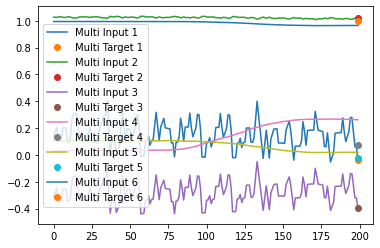

Total number of samples: 1932

Dataset:
inputs.shape: (64, 200, 6)
targets.shape: (64, 1, 6)


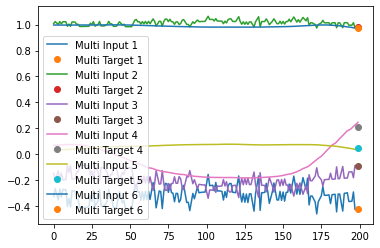

In [55]:

input_feature_dim = 6
seq_slice_len = 200
batch_size = 64
do_log = True
do_plot = True

tf_wb_1 = create_seq_to_datapoint_ds(single_westbrueck_segment, input_feature_dim, seq_slice_len, batch_size, do_log, do_plot)
tf_wb_2 = create_seq_to_datapoint_ds(single_westbrueck_segment2, input_feature_dim, seq_slice_len, batch_size, do_log, do_plot)




In [152]:
def seq_to_dp_ds_from_df_list(dfs, input_feature_dim, seq_slice_len, batch_size = 64, do_size_log = False):
    '''
    Creates a dataset from a list of dataframes including timeseries data.
    '''
    
    print("Creating dataset from Dataframe List.")
    dataset = None
    for idx, df in enumerate(dfs):
        if (idx % 10 == 0) and (idx > 0):
            print(idx, end = " ")
        curr_ds = create_seq_to_datapoint_ds(df.to_numpy(), input_feature_dim, seq_slice_len, batch_size, do_log = False, do_plot = False)
        if idx == 0:
            dataset = curr_ds
        else:
            dataset = dataset.concatenate(curr_ds)
    print()
    
    if do_size_log:
        # Get total size of dataset 
        dataset_size = tf.data.experimental.cardinality(dataset).numpy()
        print("Total number of elements in dataset:", str(dataset_size))
        for inputs, targets in dataset.take(1):
            print(f'Usual inputs.shape: {inputs.shape}')
            print(f"Usual targets.shape: {targets.shape}")
            break

    
    return dataset


def train_validation_split_ds(dataset, val_frac = 0.1, shuffle = True, shuffle_buffer = 2048):
    
    # Shuffle 
    #shuffle_buffer = 2048
    if shuffle:
        print("Shuffling dataset")
        dataset = dataset.shuffle(buffer_size = shuffle_buffer)

    # Get total size of dataset 
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    # Split into train and validate and test 
    dataset_train = dataset.take(int(dataset_size * (1 - val_frac)))
    dataset_validate = dataset.skip(int(dataset_size * (1 - val_frac)))
    
    # Get sizes of sub datasets
    train_dataset_size = tf.data.experimental.cardinality(dataset_train).numpy()
    validate_dataset_size = tf.data.experimental.cardinality(dataset_validate).numpy()
    
    print("Full Dataset size:", dataset_size)
    print("Train Dataset size:", train_dataset_size)
    print("Validate Dataset size:", validate_dataset_size)
    
    return dataset_train, dataset_validate


    

In [153]:
westbrueck_dataset = seq_to_dp_ds_from_df_list(westbrueck_condensed_segments,input_feature_dim, seq_slice_len, batch_size, do_size_log = False)

shuffle = True
val_frac = 0.1
westbrueck_dataset = train_validation_split_ds(westbrueck_dataset, val_frac, shuffle, shuffle_buffer)




Creating dataset from Dataframe List.
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 
Shuffling dataset
Full Dataset size: 15249
Train Dataset size: 13724
Validate Dataset size: 1525


In [131]:
westbrueck_condensed_segments = westbrueck_condensed_segments[0:5]

In [145]:
validation_idx = 17
validation_data = None

westbrueck_condensed_segments = []

for idx, segment in enumerate(westbrueck_segments):
    segment = segment[["HmdPosition.x","HmdPosition.y","HmdPosition.z","NoseVector.x","NoseVector.y","NoseVector.z","EyePosWorldCombined.x","EyePosWorldCombined.y","EyePosWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]]
    if idx == validation_idx:
        print("Extracted validation segment data with shape",segment.shape)
        validation_data = segment
        continue
    westbrueck_condensed_segments.append(segment)


Extracted validation segment data with shape (1767, 12)


In [69]:
dataset = tf_wb_1.concatenate(tf_wb_2)

 # Shuffle 
shuffle_buffer = 2048
dataset = dataset.shuffle(buffer_size = shuffle_buffer)

# Get total size of dataset 
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
print(dataset_size)

# Split into train and validate and test 
val_frac = 0.15
dataset_train = dataset.skip(int(dataset_size * val_frac))
dataset_validate = dataset.take(int(dataset_size * val_frac))



61


In [67]:
#Input: ["HmdPosition.x","HmdPosition.y","HmdPosition.z","NoseVector.x","NoseVector.y","NoseVector.z",
#Target: "EyePosWorldCombined.x","EyePosWorldCombined.y","EyePosWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

In [53]:
single_westbrueck_segment = westbrueck_segments[0]
single_westbrueck_segment2 = westbrueck_segments[1]

# "HmdPosition", "EyePosWorldCombined" relative to car
# "NoseVector", "EyeDirWorldCombined" relative to car 

In [54]:
single_westbrueck_segment = single_westbrueck_segment.copy(deep=True)[["HmdPosition.x","HmdPosition.y","HmdPosition.z","NoseVector.x","NoseVector.y","NoseVector.z","EyePosWorldCombined.x","EyePosWorldCombined.y","EyePosWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]].to_numpy()
single_westbrueck_segment2 = single_westbrueck_segment2.copy(deep=True)[["HmdPosition.x","HmdPosition.y","HmdPosition.z","NoseVector.x","NoseVector.y","NoseVector.z","EyePosWorldCombined.x","EyePosWorldCombined.y","EyePosWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]].to_numpy()


print(single_westbrueck_segment.shape)
print(single_westbrueck_segment2.shape)


(2089, 12)
(2131, 12)


In [9]:
print(1/0)

ZeroDivisionError: division by zero